# Poboljšanje medicinskih slika zasnovano na algoritmima histograma

Poboljšanje medicinskih slika predstavlja ključni korak u dijagnostici i lečenju pacijenata, jer kvalitet slike direktno utiče na sposobnost lekara da pravilno tumači anatomske strukture i identifikuje potencijalne probleme. Zbog prirode medicinskih slika, koje često pate od problema kao što su niski kontrast i šum, važno je primeniti tehnike poboljšanja kako bi se obezbedila što jasnija i preciznija vizuelna informacija.

Jedan od najčešće korišćenih pristupa za poboljšanje kontrasta slike je izjednačavanje histograma (HE). Međutim, iako HE može značajno poboljšati kontrast, može takođe generisati neželjene artefakte i prekomerno pojačanje kontrasta u određenim delovima slike. Da bi se rešili ovi problemi, razvijeni su različiti napredni algoritmi zasnovani na histogramu, kao što su kumulativno izjednačavanje histograma (CHE), kvadratno dinamičko izjednačavanje histograma (QDHE), i kontrastno ograničeno adaptivno izjednačavanje histograma (CLAHE).

Ovaj projekat ima za cilj da analizira i uporedi performanse ovih algoritama na različitim medicinskim slikama. Kroz implementaciju i analizu rezultata koristeći Python, pokazujemo prednosti i nedostatke svakog od pristupa.

## Obrada Histograma Slike
Obrada histograma slike predstavlja osnovu za mnoge tehnike obrade slika u prostornom domenu. Histogram slike je grafički prikaz raspodele sivih tonova u digitalnoj slici. Prikazivanje histograma pomaže u analizi učestalosti pojavljivanja različitih sivih tonova koji su prisutni u slici.

Histogram se koristi za različite svrhe, kao što su poboljšanje kontrasta, kompresija slike i segmentacija. Algoritmi zasnovani na histogramu jednostavni su za implementaciju i mogu se efikasno primeniti na različite tipove slika. Jedan od najpoznatijih algoritama u ovoj oblasti je izjednačavanje histograma (HE), koji raspoređuje nivoe intenziteta u slici tako da budu podjednako verovatni, što rezultira slikom sa povećanim dinamičkim opsegom i poboljšanim kontrastom.

Kod medicinskih slika, histogram može pružiti korisne informacije o osvetljenju slike i njenom kontrastu. Na primer, histogram koji pokriva sve moguće vrednosti u skali sivih tonova ukazuje na to da slika ima dobar kontrast i da su detalji na slici jasno vidljivi.

In [ ]:
! pip install matplotlib numpy opencv-python

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import importlib
import histogram_plots as hp


In [ ]:
importlib.reload(hp)

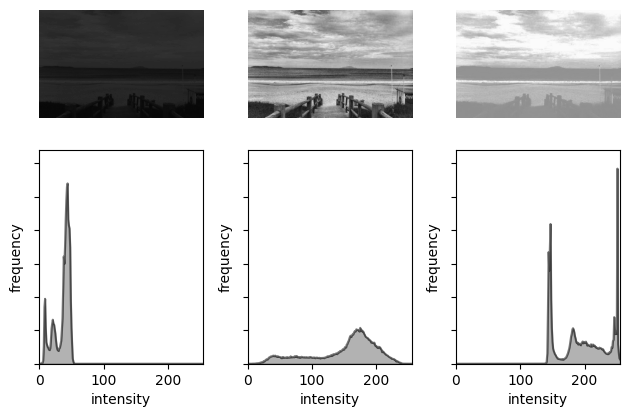

In [41]:
image_paths = [
    ('images\\dark_image.jpg'),
    ('images\\original_image.jpg'),
    ('images\\bright_image.jpg'),
]
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]
hp.show_images_and_histograms(images,y_max=16000)

### Generisanje Histograma
Histogram digitalne slike $X$ može se predstaviti sledećom formulom:
$$ 
h_X(k) = n_k 
$$ 
gde je $n_k$ broj piksela sa intenzitetom $k$.

Posmatrajući intenzitet piksela slike kao slučajnu veličinu, definišemo *normalizovani histogram* kao empirijsku verovatnoću da piksel date slike ima određenu vrednost, što se može dobiti podelom $h(k)$ sa ukupnim brojem piksela u slici dimenzije $M \times N$:
$$ p_X(k) = \frac{n_k}{MN} $$ 

## Izjednačavanje histograma 
Izjednačavanje histograma (*Histogram equalization*) transformiše vrednosti intenziteta slike tako da budu ravnomerno raspoređene po celom mogućem rasponu $[0,255]$. 

**Kumulativna distribuciona funkcija** (*CDF*) je verovatnoća da slučajna promenljiva $X$ ima vrednost *manju ili jednaku* datoj vrednosti:
$$
cdf_X(k) = \sum_{i=0}^{k}p_X(x=i).
$$

Želimo da transformišemo sliku $X$ tako da slika $Y = T(X)$ ima uniforman histogram, odnosno kumulativnu distribucionu funkciju:
$$
cdf_Y(k) = (k+1)C,
$$ 
za neku konstantu $C$.

Novu sliku dobijamo tako što piksele koji imaju intenzitet $k$ transformišemo sa:
$$
t(k) = \left \lfloor cdf_X(k)\cdot 256 \right \rfloor  .
$$

Kako se jačina intenziteta jednog piksela racuna u funkciji od njenog intenziteta na originalnoj slici, ukupan broj različitih intenziteta koji postoje na slici ostaje isti. Kako je isti broj različitih vrednosti "razvučen" sa intervala uzastopnih brojeva na veći interval, intenziteti koje neki piksel može da ima više nisu uzastopni, što vidimo na sledećem grafiku.

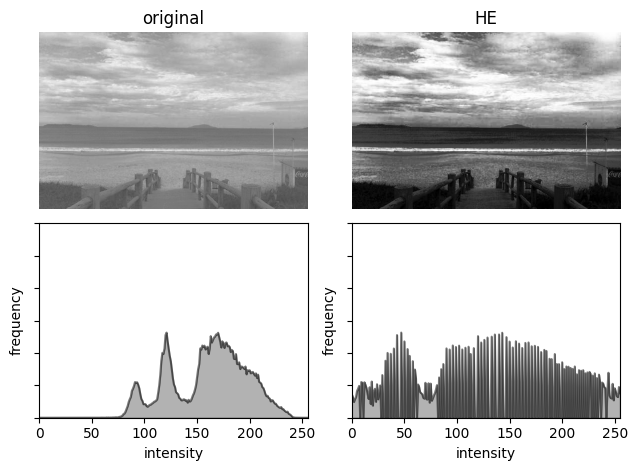

In [42]:
def cumulative_distribution_function(hist):
    total_pixels = hist.sum()    	
    norm_hist = hist / total_pixels
    cdf = np.cumsum(norm_hist)
    return cdf

def histogram_equalization(image, I_min=0, I_max=256):
    hist, _ = np.histogram(image, I_max - I_min, [I_min, I_max])
    cdf = cumulative_distribution_function(hist)
    equalized_transform = np.floor(cdf * (I_max - I_min)).astype(int)
    return equalized_transform[image]

image = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)

he_image = histogram_equalization(image)

images = [image, he_image]
hp.show_images_and_histograms(images, titles = ['original', 'HE'])

## Kvadratno Dinamičko Izjednačavanje Histograma (QDHE)

Kvadratno dinamičko izjednačavanje histograma (QDHE) je napredna tehnika poboljšanja slike koja je dizajnirana da prevaziđe neke od nedostataka standardnog izjednačavanja histograma (HE). QDHE je posebno korisno za medicinske slike jer omogućava bolje očuvanje osvetljenosti slike dok istovremeno poboljšava kontrast.

QDHE metoda kombinuje nekoliko ključnih koraka kako bi postigla poboljšanje kontrasta bez prekomernog povećanja osvetljenosti, što se često dešava kod osnovnog HE i sastoji se od četiri koraka:
1. Particionisanje histograma
2. Orezivanje histograma (clipping)
3. Dodela novih raspona sivih tonova
4. Izjednačavanje histograma 


### 1. Particionisanje histograma 
Histogram slike deli se na 4 podhistograma po kvartilima.

Ovo omogućava ravnomernu distribuciju piksela u svakom od četiri podhistograma, čime se obezbeđuje kontrolisano poboljšanje kontrasta.

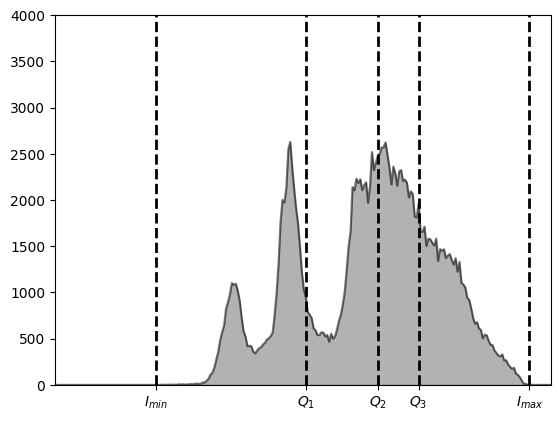

In [43]:
def partition_histogram(image):
    I_min = int(np.min(image))
    Q1 = int(np.percentile(image, 25))
    Q2 = int(np.percentile(image, 50))
    Q3 = int(np.percentile(image, 75))
    I_max = int(np.max(image))
    return [I_min, Q1, Q2, Q3, I_max]

hist, _ = np.histogram(image, 256, [0, 256])
partition_points = partition_histogram(image)

hp.show_histogram(hist=hist, xticks=partition_points)

### 2. Skraćivanje histograma (*clipping*)
Nakon particionisanja, podhistogrami se skraćuju do srednje vrednosti učestalosti intenziteta u slici. 

Ovim se ograničava maksimalan broj piksela koji ima istu vrednost, sprečavajući prekomerno pojačanje kontrasta i redukciju detalja, što pomaže u očuvanju prirodnog izgleda slike i smanjuje šum i preosvetljenje.



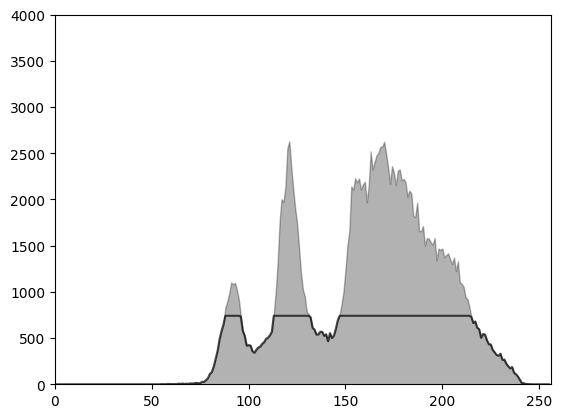

In [44]:
def clip_histogram(hist):
    threshold = hist.mean()
    clipped_hist = np.minimum(hist, threshold)
    return clipped_hist

hist, _ = np.histogram(image.flatten(), 256, [0, 256])
clipped_hist = clip_histogram(hist)

hp.show_clipped_histogram(hist=hist,clipped_hist=clipped_hist)

### 3. Dodela novog raspona sivih tonova
Svakom podhistogramu dodeljuje se novi raspon sivih tonova na osnovu njegove širine i broja piksela. Ovo omogućava ravnomerno poboljšanje kontrasta kroz celu sliku

In [45]:
def allocate_gray_levels(hist, m, L=256):
    total_pixels = hist.sum()
    
    spans = [m[i + 1] - m[i] for i in range(len(m) - 1)]
    total_span = sum(spans)
    ranges = [round((L - 1) * span / total_span) for span in spans]
    
    starts = [0] 
    ends = []

    for i in range(len(ranges)):
        if i > 0:
            starts.append(ends[i - 1])  
        end = starts[i] + ranges[i]
        ends.append(end)

    return starts, ends    

hist, _ = np.histogram(image.flatten(), 256, [0, 256])
m = partition_histogram(image)
gray_starts, gray_ends = allocate_gray_levels(hist, m)
print("original gray intervals :", *zip(m[:-1], m[1:]))
print("new gray intervals : ",*zip(gray_starts,gray_ends))

original gray intervals : (52, 129) (129, 166) (166, 187) (187, 244)
new gray intervals :  (0, 102) (102, 151) (151, 179) (179, 255)


### 4. Izjednačavanje histograma (HE) za svaki podhistogram:
Na kraju, HE se primenjuje na svaki od pod-histograma nezavisno. Ovo omogućava dinamičnije poboljšanje kontrasta u slici, jer se svaki deo opsega sive odvojeno normalizuje.


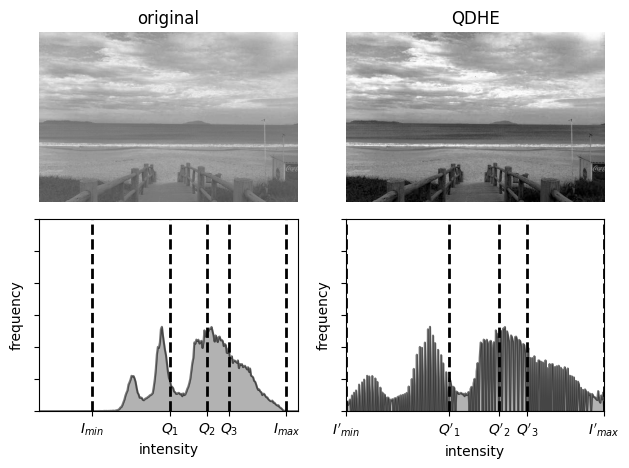

In [48]:
hist, _ = np.histogram(image, 256, [0, 256])
m = partition_histogram(image)
clipped_hist = clip_histogram(hist)

new_starts, new_ends = allocate_gray_levels(clipped_hist, m)
equalized_image = np.zeros_like(image)

for i, (new_start, new_end) in enumerate(zip(new_starts, new_ends)):
    start = m[i]
    end  = m[i+1]
    mask = (image >= start) & (image < end)

    sub_hist = clipped_hist[start:end]
    cdf = cumulative_distribution_function(sub_hist)
    equalized_transform = np.floor(cdf * (new_end - new_start)).astype(int) + new_start
    equalized_image[mask] = equalized_transform[image[mask] - start]  

hp.show_images_and_histograms([image,equalized_image], titles=['original', 'QDHE'], xticks = [m[:],new_starts+[new_ends[-1]]], labels = [[r"$I_{min}$", r"$Q_{1}$", r"$Q_{2}$", r"$Q_{3}$", r"$I_{max}$"],[r"$I'_{min}$",r"$Q'_{1}$", r"$Q'_{2}$", r"$Q'_{3}$",r"$I'_{max}$"]])

### Prednosti QDHE:
- **Očuvanje osvetljenosti**: Za razliku od standardnog HE, QDHE ima sposobnost da bolje očuva ukupnu osvetljenost slike. Ovo je važno za medicinske slike gde je očuvanje prirodne osvetljenosti ključno za tačnu dijagnozu.

- **Smanjeno preosvetljenje**: Korišćenjem odsecanja, QDHE smanjuje rizik od preosvetljenja i prekomernog kontrasta u nekim delovima slike, što rezultira prirodnijim izgledom slike.

- **Bolje lokalno poboljšanje**: Deljenjem histograma u podhistograme i primenom HE na svaki podhistogram, QDHE omogućava bolje lokalno poboljšanje kontrasta, što može biti korisno za detekciju finih detalja u medicinskim slikama.